# Load dataset:

In [1]:
from components.models.utils import train_test_split
from components.datasets.dataset_factory import dataset_factory
from components.datasets.dataset_enum import Dataset
from components.text_handler.embedding.embedding_enum import EmbeddingType
from components.text_handler.embedding.embedding_factory import embedding_factory

embedding = embedding_factory(EmbeddingType.GLOVE)
dataset = dataset_factory(Dataset.GO_EMOTIONS, embedding)
train_dataset_data, train_dataset_labels, test_dataset_data, test_dataset_labels = train_test_split(dataset, 0.85)
train_size = len(train_dataset_data)
test_size = len(test_dataset_data)


# Create model:
* Only GRU for now

In [2]:
import torch
from torch import nn
from components.models.algorithms.gru import GRU

input_size = 100
output_size = 28 # we have 28 labels
hidden_size = 64
learning_rate = 0.0004
batch_size = 32
num_epochs = 10

model = GRU(input_size, output_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define metrics objects:

In [3]:
import torchmetrics

accuracy = torchmetrics.Accuracy()
roc_accuracy = torchmetrics.AUROC(num_classes=output_size)
F1_accuracy = torchmetrics.F1Score(num_classes=output_size)

/Users/nadavalali/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


# Train model:

In [4]:
from tqdm import tqdm
from components.models.utils import shuffle, feed_model

LOSS = "loss"
TRAIN = "train"
TEST = "test"
ACC = "accuracy"
ROC = "roc accuracy"
F1 = "F1 accuracy"

measurements = {
    LOSS: {TRAIN: [], TEST: []},
    ACC: {TRAIN: [], TEST: []},
    ROC: {TRAIN: [], TEST: []},
    F1: {TRAIN: [], TEST: []}
}

for epoch in tqdm(range(num_epochs)):

    # train the model
    feed_model(model, hidden_size, train_dataset_data, train_dataset_labels, train_size,
               batch_size, criterion, optimizer, accuracy, roc_accuracy, F1_accuracy, measurements, TRAIN)

    # test the model
    feed_model(model, hidden_size, test_dataset_data, test_dataset_labels, test_size,
               batch_size, criterion, optimizer, accuracy, roc_accuracy, F1_accuracy, measurements, TEST)

    # shuffle train set
    train_dataset_data, train_dataset_labels = shuffle(train_dataset_data, train_dataset_labels)


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/mg/c1b82dqd5r71hy_2bq_yx1f80000gn/T/ipykernel_2260/114245503.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  labels = torch.tensor(train_dataset_labels[train_index: train_index + batch_size], dtype=float)
/Users/nadavalali/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/nadavalali/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  war

# Plot results:

Plotting results:

loss: train=3.3550321073752816, test=3.361219483716319


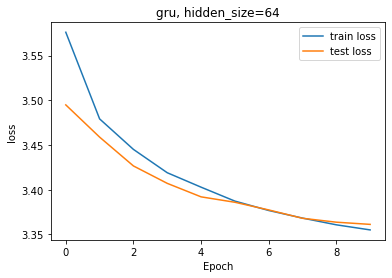

accuracy: train=0.8364153504371643, test=0.8351499438285828


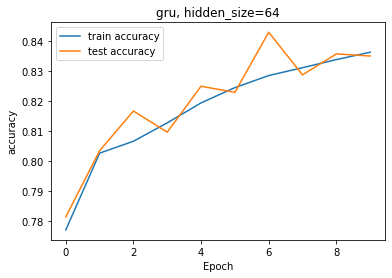

roc accuracy: train=0.4904089868068695, test=0.4849180579185486


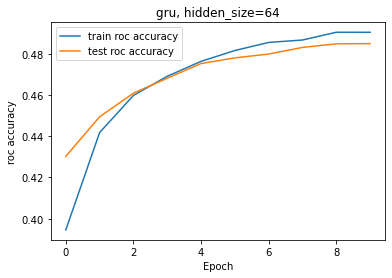

F1 accuracy: train=0.28434184193611145, test=0.277725487947464


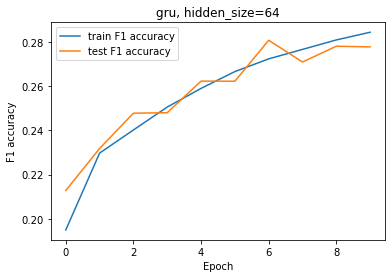

In [5]:
from matplotlib import pyplot as plt

if len(measurements[LOSS][TRAIN]):
    print("Plotting results:\n")
    for measurement_key, measurement in measurements.items():
        print(f"{measurement_key}: train={measurement[TRAIN][-1]}, test={measurement[TEST][-1]}")

        plt.title(f'{"gru"}, hidden_size={hidden_size}')
        plt.xlabel('Epoch')
        plt.ylabel(measurement_key)
        plt.plot(measurement[TRAIN], label=f'train {measurement_key}')
        plt.plot(measurement[TEST], label=f'test {measurement_key}')
        plt.legend()
        plt.show()
else:
    print("You didn't run the training step!")